##### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.impute import KNNImputer
from scipy.stats import f_oneway
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

##### Load the dataset

In [4]:
data = pd.read_csv('customer_behavior_analytcis.csv')  # Replace with your actual file path

print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nNumber of duplicate rows:", data.duplicated().sum())

Dataset Shape: (999, 6)

First few rows:
   total_purchases  avg_cart_value  total_time_spent  product_click  \
0              7.0          129.34             52.17           18.0   
1             22.0           24.18              9.19           15.0   
2              2.0           32.18             90.69           50.0   
3             25.0           26.85             11.22           16.0   
4              7.0          125.45             34.19           30.0   

   discount_counts customer_id  
0              0.0     CM00000  
1              7.0     CM00001  
2              2.0     CM00002  
3             10.0     CM00003  
4              3.0     CM00004  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_purchases   979 non-null    float64
 1   avg_cart_value    979 non-null    float64
 2   total_time_spent  999 

##### Data Cleaning
###### Handle missing values using KNNImputer

In [6]:
imputer = KNNImputer(n_neighbors=2)
imputed_data = pd.DataFrame(imputer.fit_transform(data.drop('customer_id', axis=1)), 
                          columns=['total_purchases', 'avg_cart_value', 'total_time_spent', 
                                  'product_click', 'discount_counts'])

In [7]:
imputed_data.head()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
0,7.0,129.34,52.17,18.0,0.0
1,22.0,24.18,9.19,15.0,7.0
2,2.0,32.18,90.69,50.0,2.0
3,25.0,26.85,11.22,16.0,10.0
4,7.0,125.45,34.19,30.0,3.0


##### Exploratory Data Analysis (EDA)

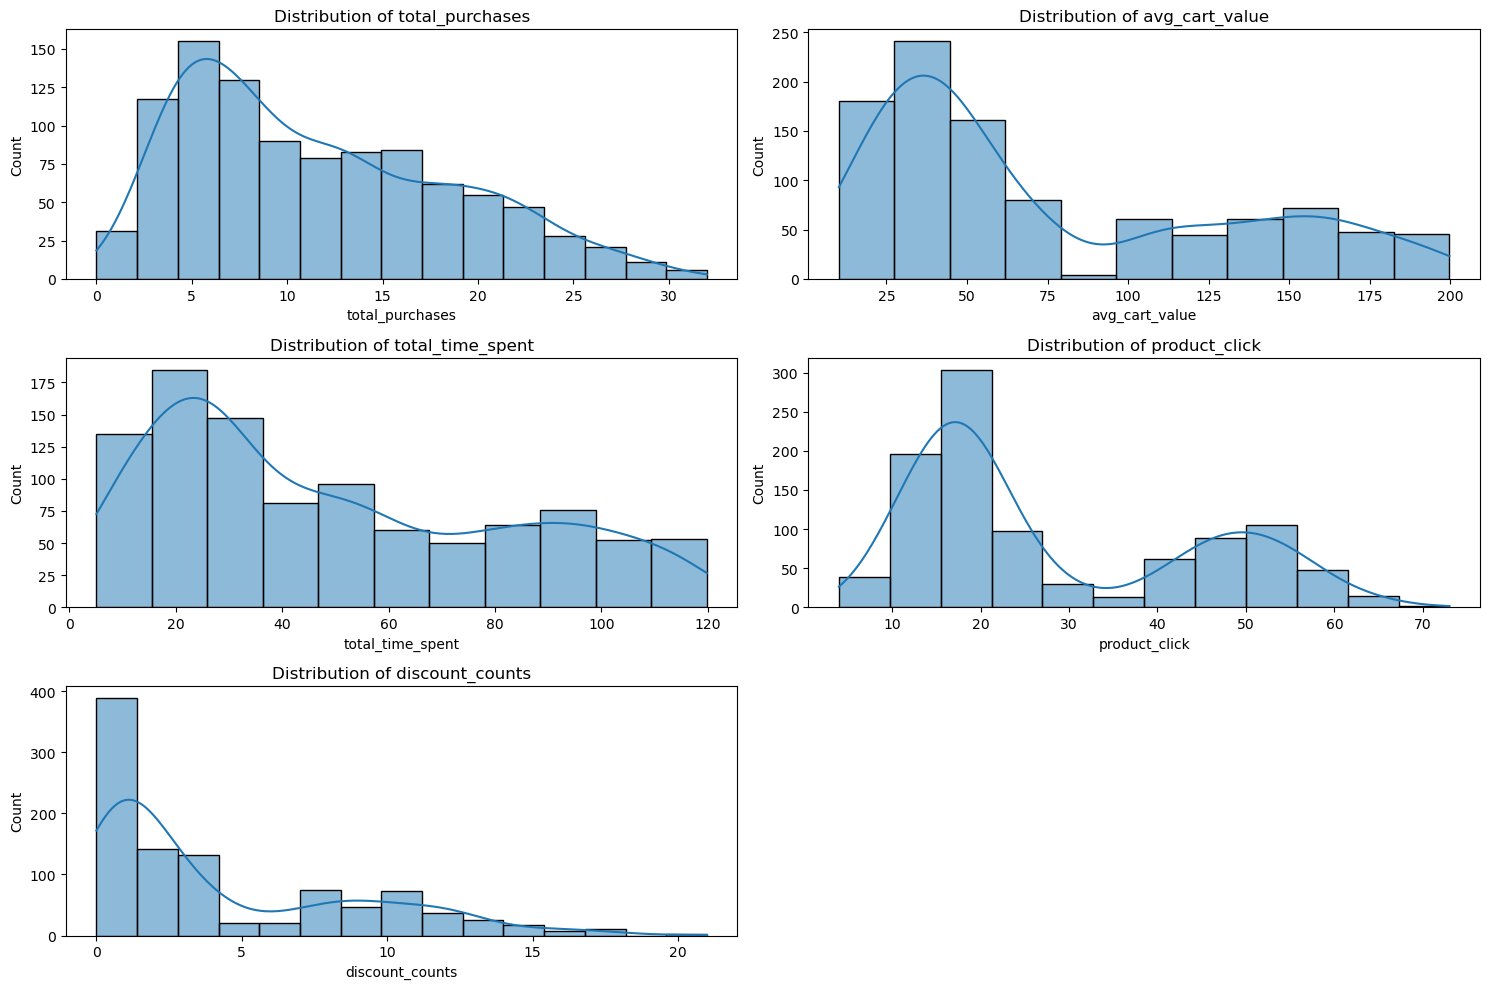

In [9]:
X = imputed_data

# Histograms
#features = ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']
features = list(imputed_data.columns)
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.histplot(X[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.savefig('histograms.png', dpi=300, bbox_inches='tight')
plt.show()

##### Box plots for outlier detection

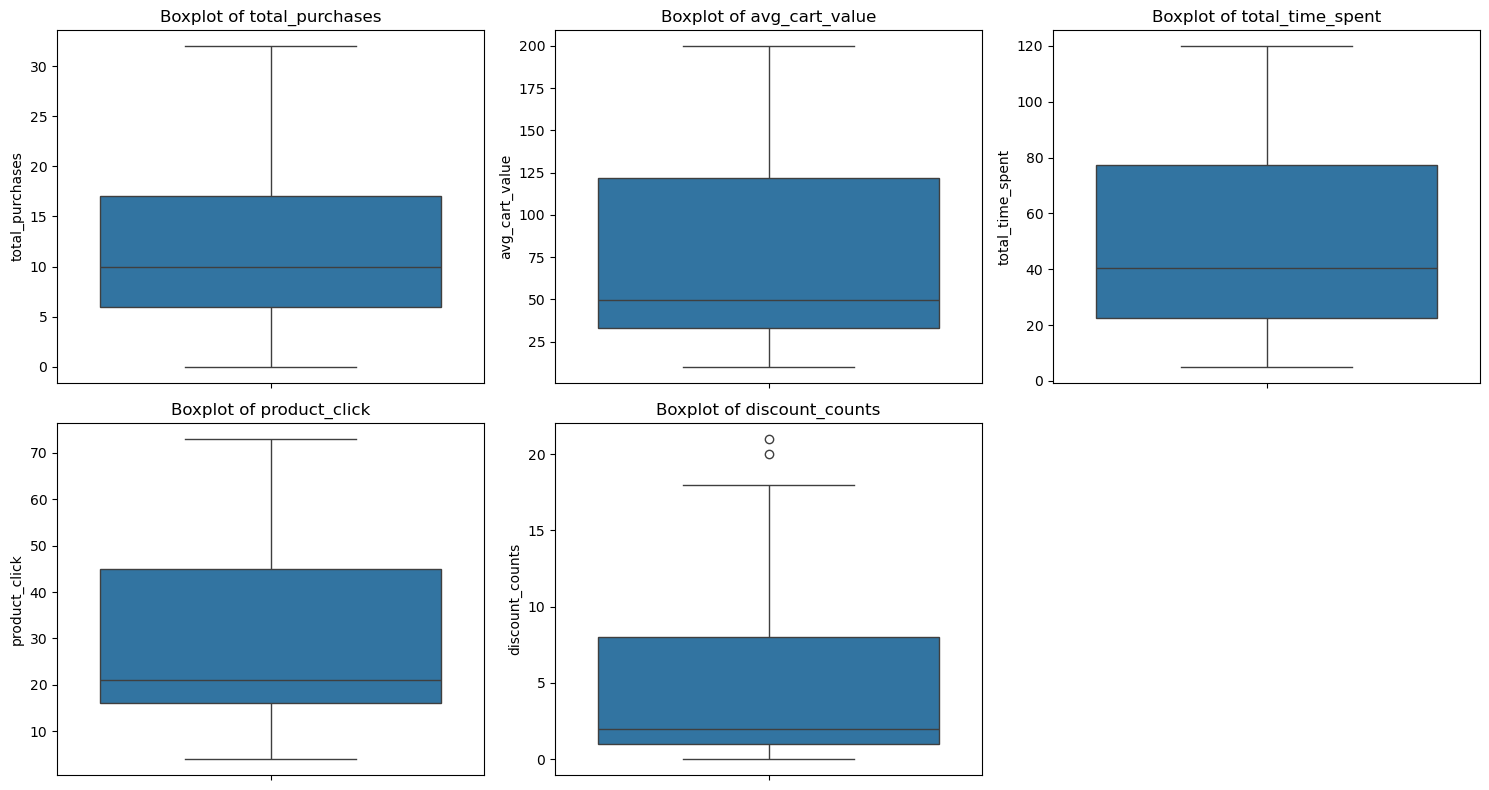

In [11]:
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=X[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.savefig('boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

##### Pairplot

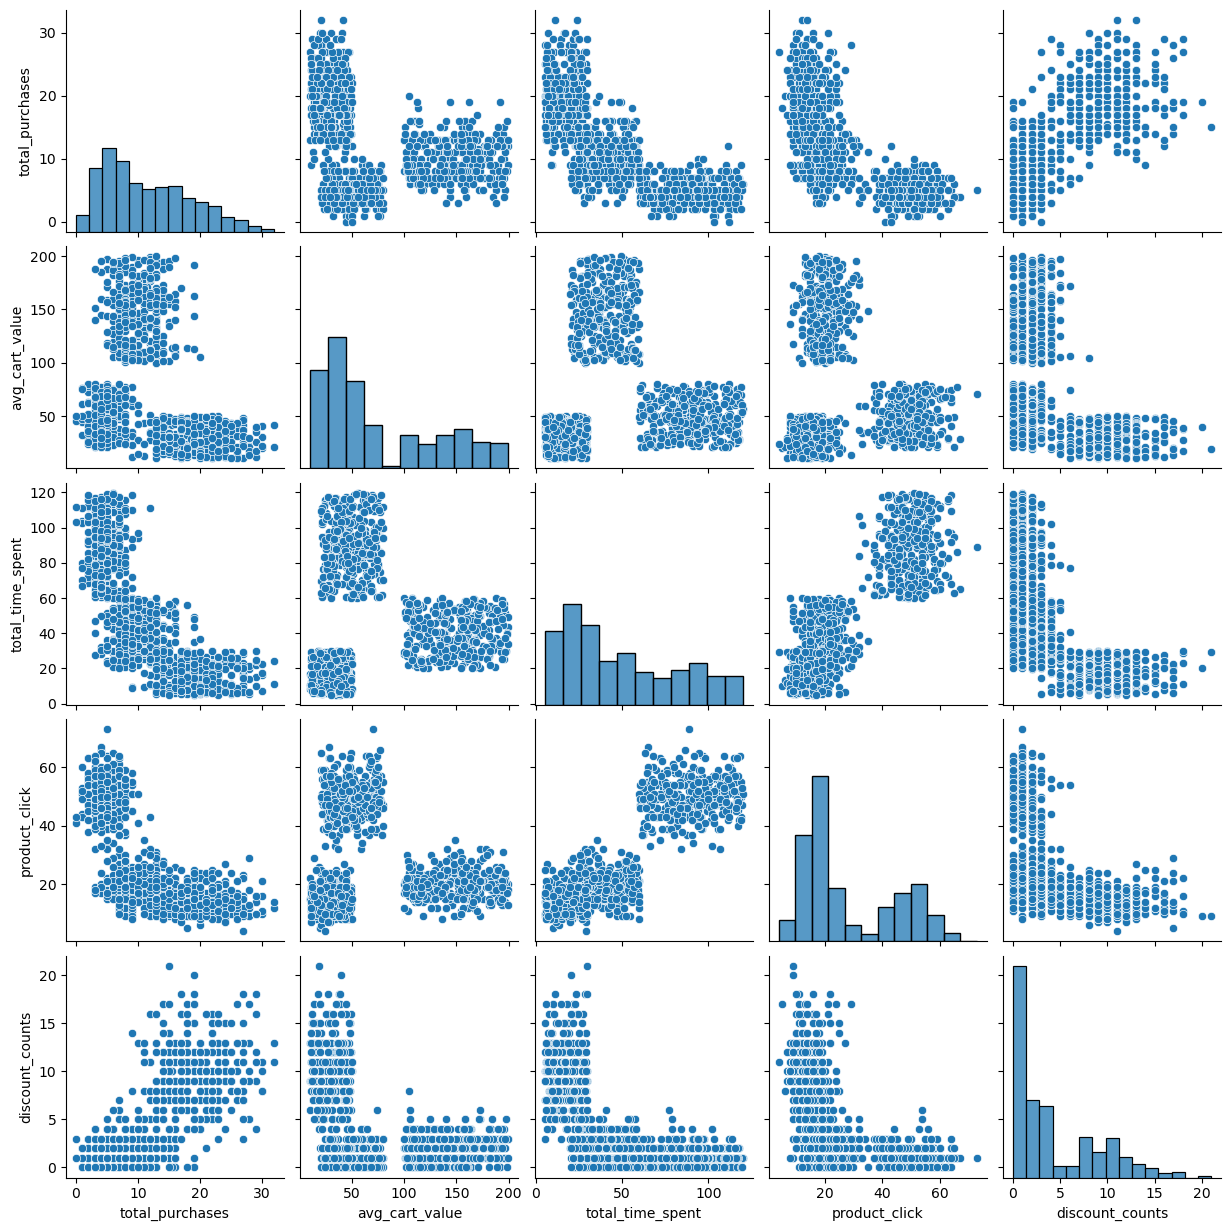

In [13]:
sns.pairplot(X)
plt.savefig('pairplot_eda.png.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
print(X.dtypes)

total_purchases     float64
avg_cart_value      float64
total_time_spent    float64
product_click       float64
discount_counts     float64
dtype: object


##### Correlation matrix

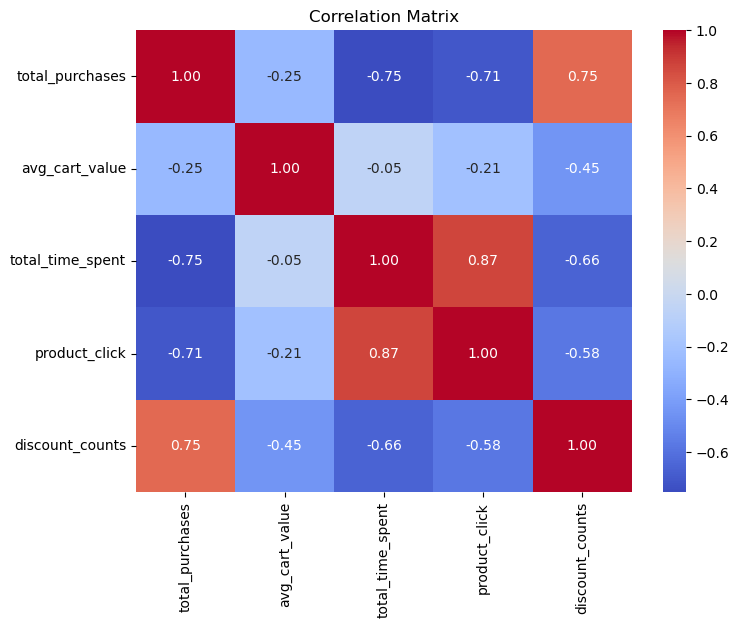

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(X.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

##### Statistical summary

In [18]:
print("\nSkewness of Features:")
print(X.skew())
print("\nKurtosis of Features:")
print(X.kurtosis())


Skewness of Features:
total_purchases     0.639375
avg_cart_value      0.783240
total_time_spent    0.564760
product_click       0.696017
discount_counts     1.070385
dtype: float64

Kurtosis of Features:
total_purchases    -0.541259
avg_cart_value     -0.806900
total_time_spent   -0.943590
product_click      -1.009823
discount_counts     0.096899
dtype: float64


##### Data Preprocessing
###### Standardize the numeric features

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### Apply K-Means Clustering
###### Run K-Means with k=3

In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
X['Cluster'] = kmeans.labels_
#imputed_data['Cluster'] = kmeans.labels_

In [23]:
# Check cluster distribution
print("\nCluster Distribution:")
print(imputed_data['Cluster'].value_counts())


Cluster Distribution:
Cluster
0    333
2    333
1    333
Name: count, dtype: int64


##### Cluster Analysis
###### Compute mean values per cluster

In [25]:
cluster_profiles = X.groupby('Cluster').mean()
print("\nCluster Profiles (Mean Values):")
print(cluster_profiles)


Cluster Profiles (Mean Values):
         total_purchases  avg_cart_value  total_time_spent  product_click  \
Cluster                                                                     
0              10.183183      147.059625         40.389730      19.899399   
1               4.858859       49.051997         90.144865      49.710210   
2              19.662162       30.430195         17.511682      14.923423   

         discount_counts  
Cluster                   
0               1.945946  
1               1.024024  
2               9.969970  


##### Visualize cluster characteristics using box plots

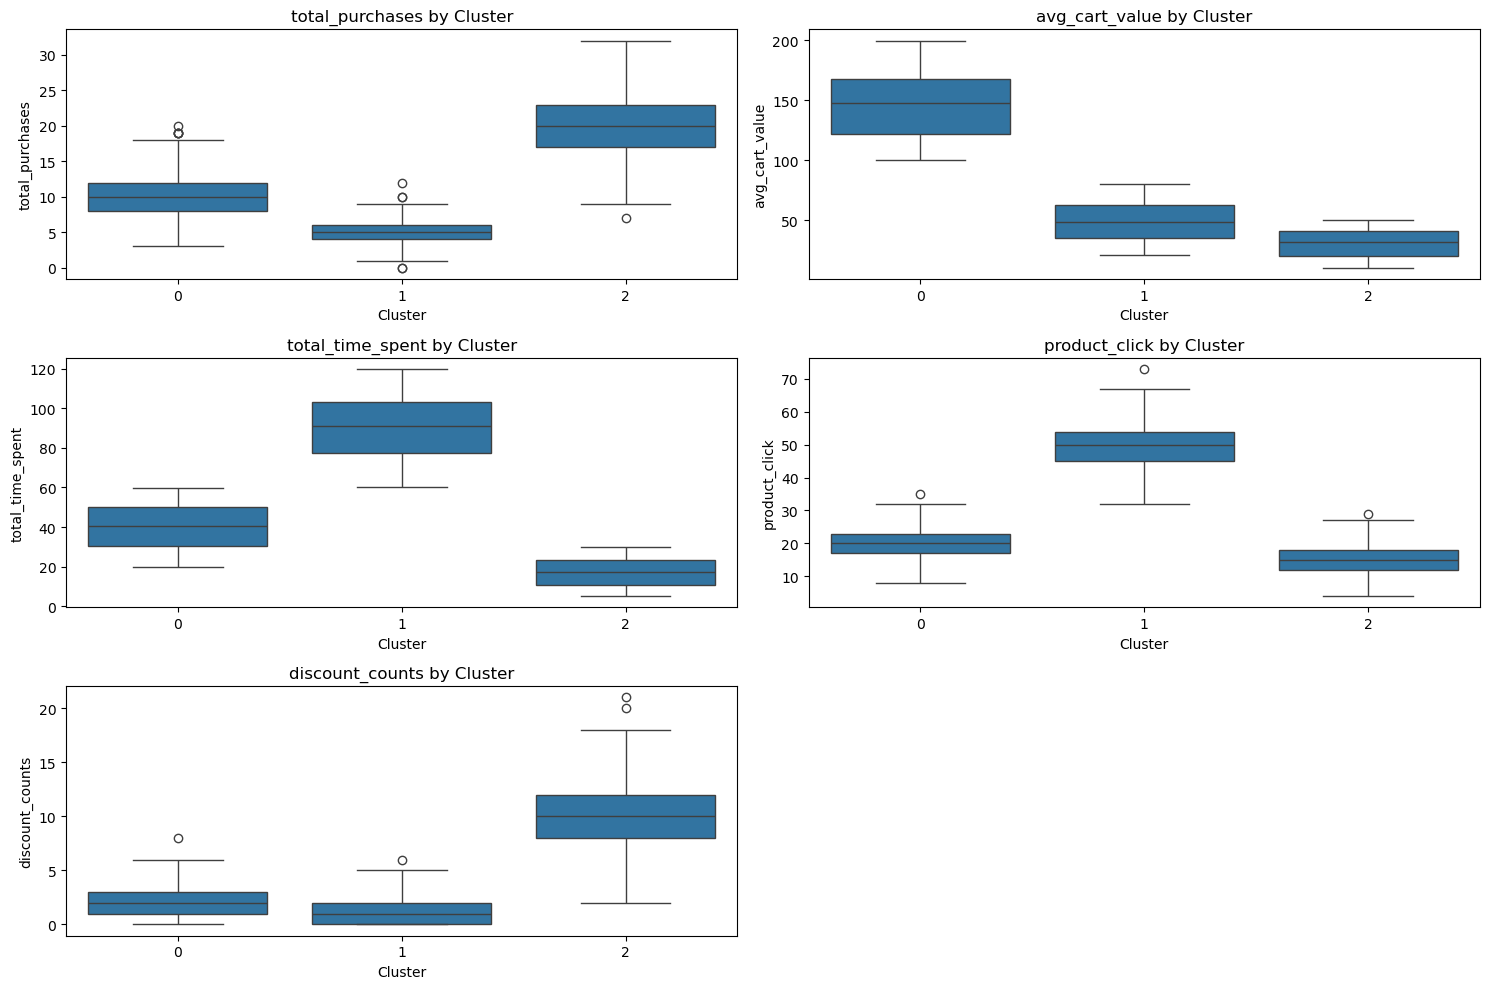

In [27]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=X)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.savefig('boxplots_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Statistical test for feature differences across clusters
print("\nANOVA Test for Feature Differences Across Clusters:")
for feature in features:
    groups = [X[feature][X['Cluster'] == i] for i in range(3)]
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA for {feature}: F-statistic={f_stat:.2f}, p-value={p_val:.4f}")


ANOVA Test for Feature Differences Across Clusters:
ANOVA for total_purchases: F-statistic=1639.41, p-value=0.0000
ANOVA for avg_cart_value: F-statistic=3244.94, p-value=0.0000
ANOVA for total_time_spent: F-statistic=3035.21, p-value=0.0000
ANOVA for product_click: F-statistic=4141.79, p-value=0.0000
ANOVA for discount_counts: F-statistic=1833.10, p-value=0.0000


#### Visualization of Clusters
##### Pairplot with clusters

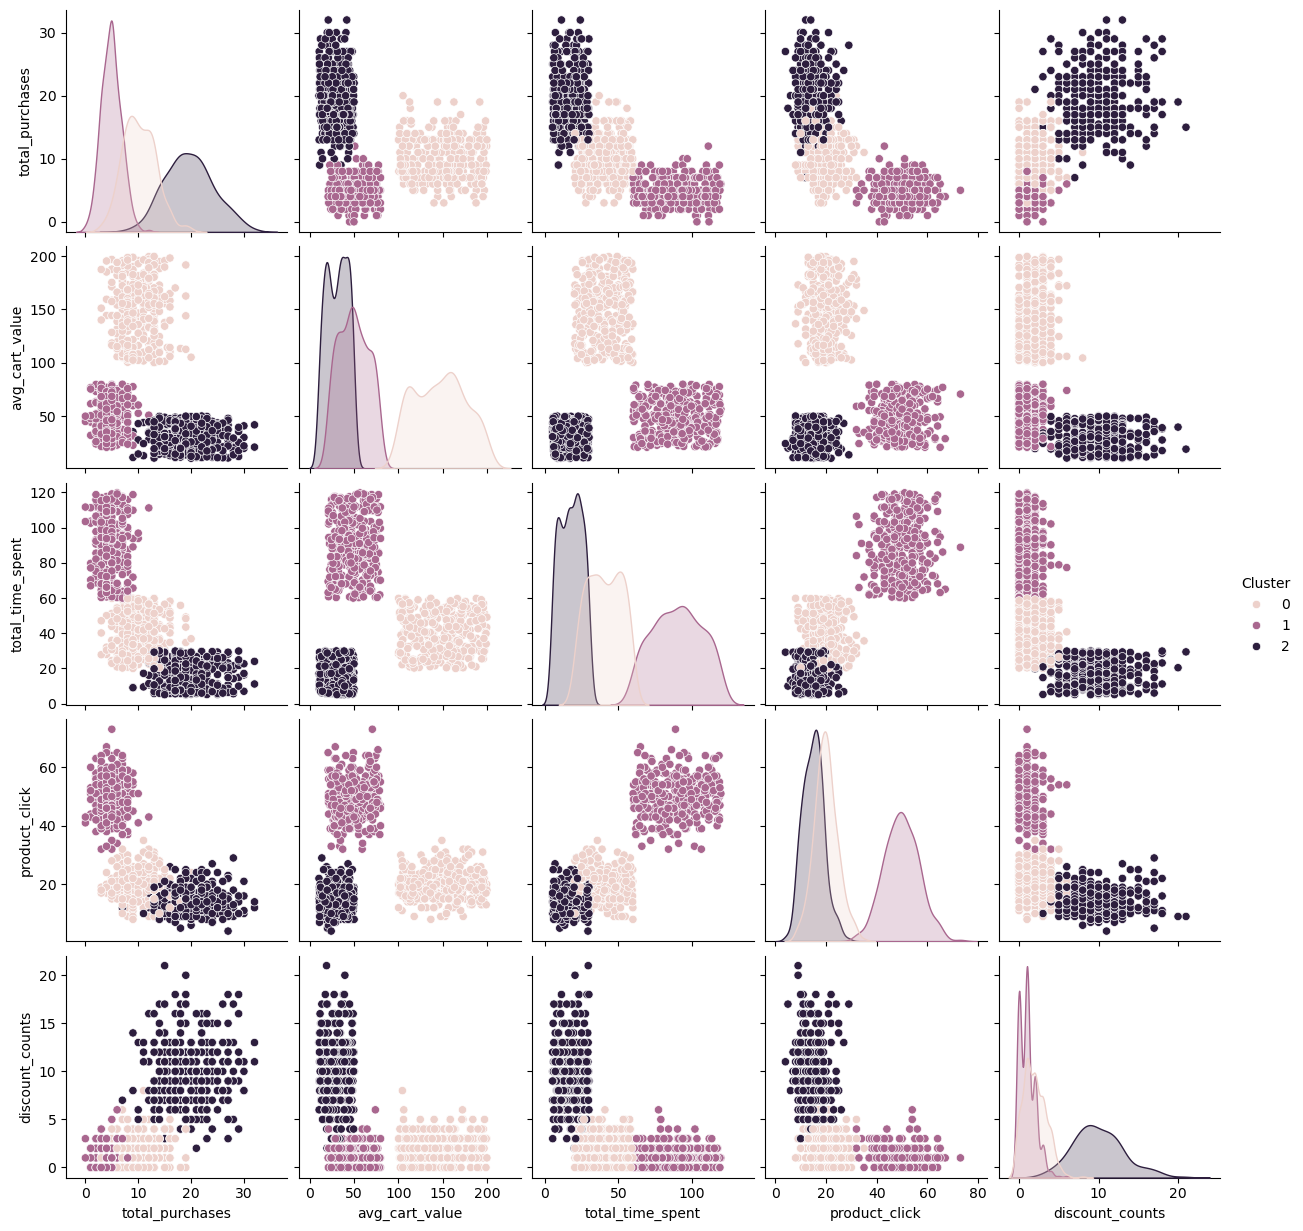

In [30]:
sns.pairplot(X, hue='Cluster', vars=features)
plt.savefig('pairplot_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

#### PCA for 2D visualization

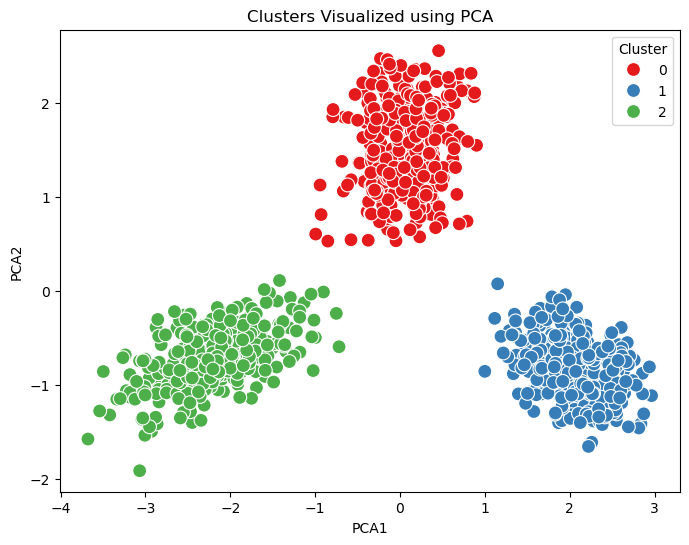


Explained Variance Ratio by PCA components: [0.63694707 0.26095403]


In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['PCA1'] = X_pca[:, 0]
X['PCA2'] = X_pca[:, 1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=X, palette='Set1', s=100)
plt.title('Clusters Visualized using PCA')
plt.savefig('pca_clusters.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nExplained Variance Ratio by PCA components:", pca.explained_variance_ratio_)

#### t-SNE for 2D visualization

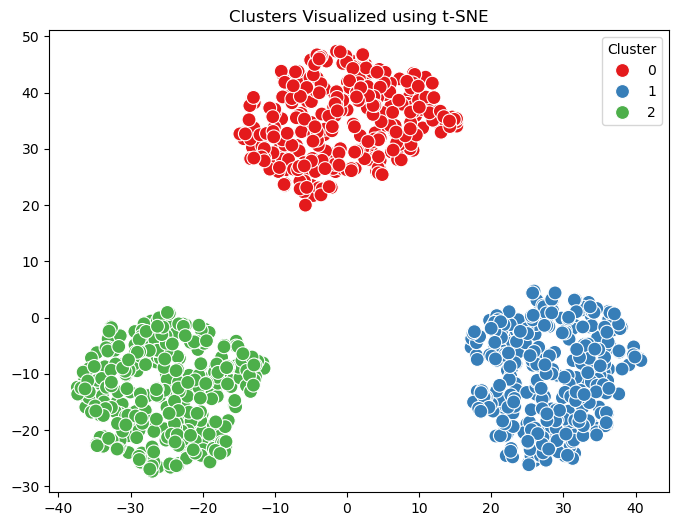

In [34]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X['Cluster'], palette='Set1', s=100)
plt.title('Clusters Visualized using t-SNE')
plt.savefig('tsne_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

#### Model Evaluation
##### Compute inertia and silhouette score

In [36]:
inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print("\nK-Means Inertia:", inertia)
print("K-Means Silhouette Score:", silhouette_avg)


K-Means Inertia: 827.1289248604171
K-Means Silhouette Score: 0.6266831238874849


##### Additional metrics

In [38]:
db_score = davies_bouldin_score(X_scaled, kmeans.labels_)
ch_score = calinski_harabasz_score(X_scaled, kmeans.labels_)
print("Davies-Bouldin Score:", db_score)
print("Calinski-Harabasz Score:", ch_score)

Davies-Bouldin Score: 0.5490126451148044
Calinski-Harabasz Score: 2509.402987895487


#### Silhouette plot

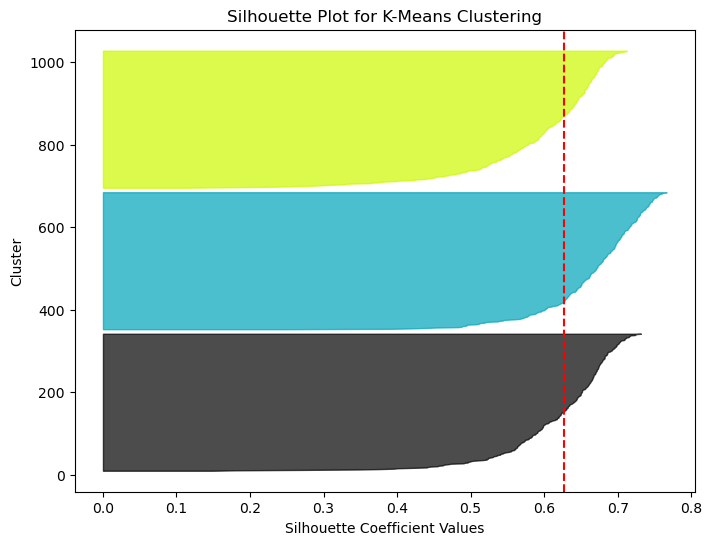

In [40]:
silhouette_vals = silhouette_samples(X_scaled, kmeans.labels_)
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(3):
    cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette Plot for K-Means Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")
plt.savefig('silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Elbow method and silhouette scores for different k

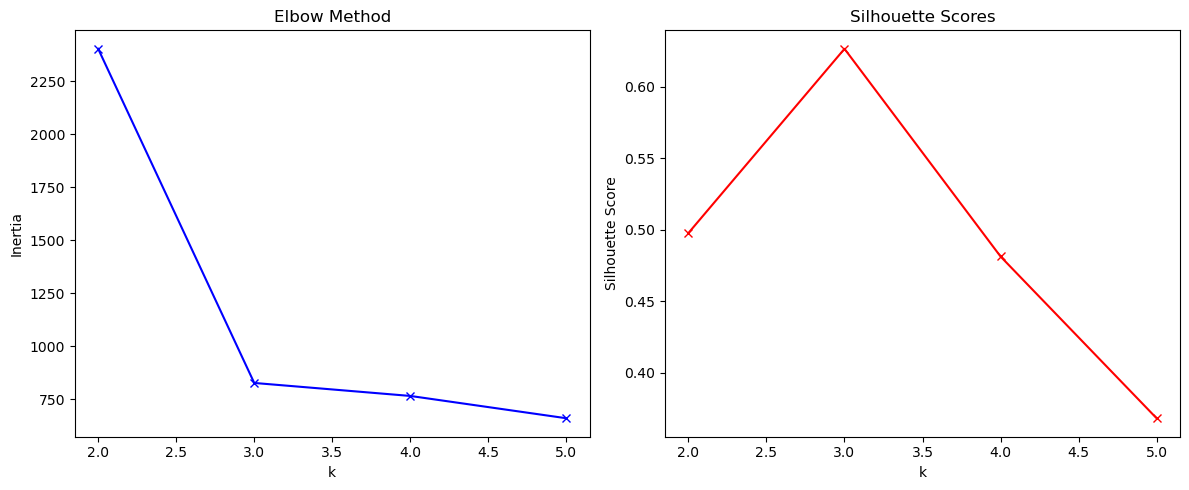

In [42]:
inertias, silhouette_scores = [], []
K = range(2, 6)
for k in K:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X_scaled)
    inertias.append(kmeans_test.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans_test.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.savefig('elbow_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

##### Compare with DBSCAN

In [44]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print("\nDBSCAN Number of Clusters:", n_clusters_dbscan)
print("DBSCAN Number of Noise Points:", list(dbscan_labels).count(-1))
if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(X_scaled, dbscan_labels)
    print("DBSCAN Silhouette Score:", silhouette_dbscan)
else:
    print("DBSCAN Silhouette Score: Not applicable (too few clusters)")


DBSCAN Number of Clusters: 4
DBSCAN Number of Noise Points: 93
DBSCAN Silhouette Score: 0.3684393498786491


##### Compare with Hierarchical Clustering

In [46]:
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(X_scaled)
silhouette_hierarchical = silhouette_score(X_scaled, hierarchical_labels)
print("\nHierarchical Clustering Silhouette Score:", silhouette_hierarchical)


Hierarchical Clustering Silhouette Score: 0.6266831238874849


#### Dendrogram

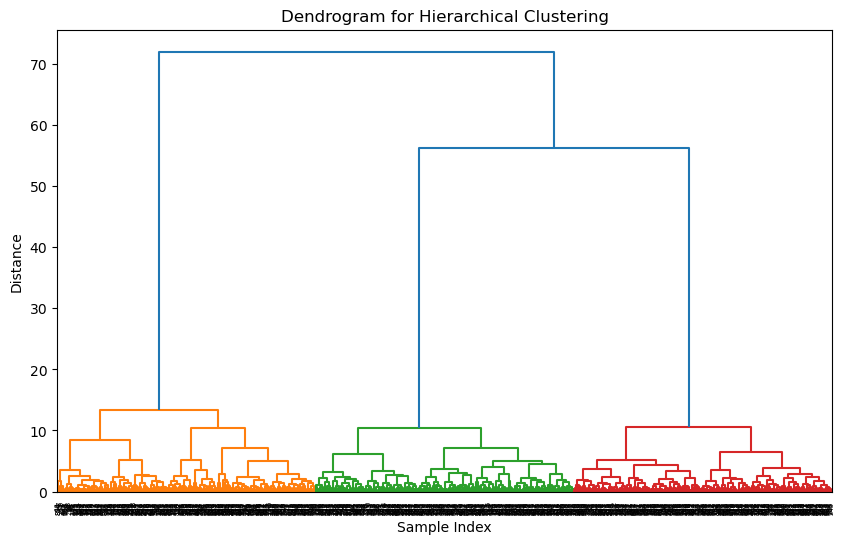

In [48]:
plt.figure(figsize=(10, 6))
Z = linkage(X_scaled, method='ward')
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

#### Cluster Interpretation

In [50]:
print("\nCluster Interpretation based on characteristics:")
for cluster in range(3):
    profile = cluster_profiles.loc[cluster]
    print(f"\nCluster {cluster}:")
    print(f"- Total Purchases: {profile['total_purchases']:.2f}")
    print(f"- Avg Cart Value: {profile['avg_cart_value']:.2f}")
    print(f"- Total Time Spent: {profile['total_time_spent']:.2f}")
    print(f"- Product Clicks: {profile['product_click']:.2f}")
    print(f"- Discount Counts: {profile['discount_counts']:.2f}")


Cluster Interpretation based on characteristics:

Cluster 0:
- Total Purchases: 10.18
- Avg Cart Value: 147.06
- Total Time Spent: 40.39
- Product Clicks: 19.90
- Discount Counts: 1.95

Cluster 1:
- Total Purchases: 4.86
- Avg Cart Value: 49.05
- Total Time Spent: 90.14
- Product Clicks: 49.71
- Discount Counts: 1.02

Cluster 2:
- Total Purchases: 19.66
- Avg Cart Value: 30.43
- Total Time Spent: 17.51
- Product Clicks: 14.92
- Discount Counts: 9.97


In [51]:
# Final mapping based on characteristics
imputed_data['Segment'] = imputed_data['Cluster'].map({
    0: "High Spenders",    # High avg_cart_value, moderate purchases, low discounts
    1: "Window Shoppers",  # Low purchases, high time spent, high clicks
    2: "Bargain Hunters"   # High purchases, low cart value, high discounts
})

In [52]:
# Print segment distribution
print("\nSegment Distribution:")
print(imputed_data['Segment'].value_counts())


Segment Distribution:
Segment
High Spenders      333
Bargain Hunters    333
Window Shoppers    333
Name: count, dtype: int64


In [53]:
# Prepare a summary report
print("\nSegmentation Insights:")
print("1. High Spenders: Moderate purchases, high cart value, moderate time spent, low discount usage.")
print("2. Window Shoppers: Low purchases, high browsing time, many product clicks, low discount usage.")
print("3. Bargain Hunters: High purchases, low cart value, moderate time spent, high discount usage.")
print("\nCluster Profiles (Mean Values):")
print(cluster_profiles)


Segmentation Insights:
1. High Spenders: Moderate purchases, high cart value, moderate time spent, low discount usage.
2. Window Shoppers: Low purchases, high browsing time, many product clicks, low discount usage.
3. Bargain Hunters: High purchases, low cart value, moderate time spent, high discount usage.

Cluster Profiles (Mean Values):
         total_purchases  avg_cart_value  total_time_spent  product_click  \
Cluster                                                                     
0              10.183183      147.059625         40.389730      19.899399   
1               4.858859       49.051997         90.144865      49.710210   
2              19.662162       30.430195         17.511682      14.923423   

         discount_counts  
Cluster                   
0               1.945946  
1               1.024024  
2               9.969970  


In [54]:
# Business recommendations
print("\nBusiness Recommendations:")
print("1. High Spenders: Focus on premium products and personalized recommendations.")
print("2. Window Shoppers: Use retargeting campaigns or incentives to convert browsing into purchases.")
print("3. Bargain Hunters: Offer frequent discounts or bundle deals to encourage more purchases.")


Business Recommendations:
1. High Spenders: Focus on premium products and personalized recommendations.
2. Window Shoppers: Use retargeting campaigns or incentives to convert browsing into purchases.
3. Bargain Hunters: Offer frequent discounts or bundle deals to encourage more purchases.
